# Benchmarking - Plotting the found key points

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cv2 import circle
import numpy as np
import cv2 as cv

import torch
from models.matching import Matching
from cv_image_matching.utils.utils import get_images, run_feature_extracion_own

from cv_image_matching.benchmarks.fundamental_matrix import run_feature_extraction_loftr

### Load image

In [2]:
src = "../data/train"
folder = "lincoln_memorial_statue"
idx = 18
data_path = src + "/" + folder + "/pair_covisibility.csv"
img_size = (200, 200)
data = pd.read_csv(data_path)

img1_id = data.iloc[idx]["pair"].split("-")[0]
img2_id = data.iloc[idx]["pair"].split("-")[1]

img1_path = src + "/" + folder + "/images/" + img1_id + ".jpg"
img2_path = src + "/" + folder + "/images/" + img2_id + ".jpg"

gray1, gray2, resized_img1, resized_img2 = get_images(
    img1_path,
    img2_path,
    img_size,
    show=False,
)

### Run SIFT (Own and OpenCV)

In [3]:
params_sift = {
    "kp_find_threshold": 1,
    "kp_max_tolerance": 0,
    "local_max_threshold": 10,
    "initial_sigma": 1.6,
    "n_scales_per_octave": 3,
    "n_octaves": 8,
    "assumed_blur": 0.5,
    "gaussian_window_histogram": 1.5,
    "num_bins_histogram": 180,
    "ksize_smooth_histogram": 5,
    "std_smooth_histogram": 1,
    "size_factor": 5,
    "n_spacial_bins": 4,
    "n_orientation_bins": 8,
    "f_max": 0.2,
    "f_scale": 512,
    "descriptor_filter_scale_factor": 0.25,
    "descriptor_cutoff_factor": 2.5,
}


experiments = ["own_sift", "opencv_sift", "superglue", "loftr"]
exp = "own_sift"
kp1, des1, kp2, des2 = run_feature_extracion_own(gray1, gray2, params_sift)
img_own = resized_img1.copy()
cv.drawKeypoints(gray1, kp1, img_own)

sift_opencv = cv.SIFT_create()
kp1, des1 = sift_opencv.detectAndCompute(resized_img1.copy(), None)
img_opencv = resized_img1.copy()
img_opencv = cv.drawKeypoints(gray1, kp1, img_opencv)

Calculated keypoints and descriptors for image 1
Time taken for own SIFT:  2.764296054840088  seconds
Calculated keypoints and descriptors for image 2
Time taken for OpenCV SIFT:  3.3614768981933594  seconds


### SuperGlue

In [4]:
config = {
    "superpoint": {
        "nms_radius": 3,
        "keypoint_threshold": 0.005,
        "max_keypoints": 2048,
    },
    "superglue": {
        "weights": "outdoor",
        "sinkhorn_iterations": 100,
        "match_threshold": 0.2,
    },
}
matching = Matching(config).eval().to('cpu')
img1_glue = torch.from_numpy(gray1)[None][None] / 255.0
img2_glue = torch.from_numpy(gray2)[None][None] / 255.0

pred = matching({"image0": img1_glue, "image1": img2_glue})
pred = {k: v[0].detach().cpu().numpy() for k, v in pred.items()}
kp1, _ = pred["keypoints0"], pred["keypoints1"]

img_superglue = resized_img1.copy()
for point in kp1:
    circle(img_superglue, (int(point[0]), int(point[1])), 2, (0, 255, 0), 1)

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


### LoFTR

In [5]:
f, kp1, kp2 = run_feature_extraction_loftr(gray1, gray2)
img_loftr = resized_img1.copy()
for point in kp1:
    circle(img_loftr, (int(point[0]), int(point[1])), 2, (0, 255, 0), 1)

### Plot images

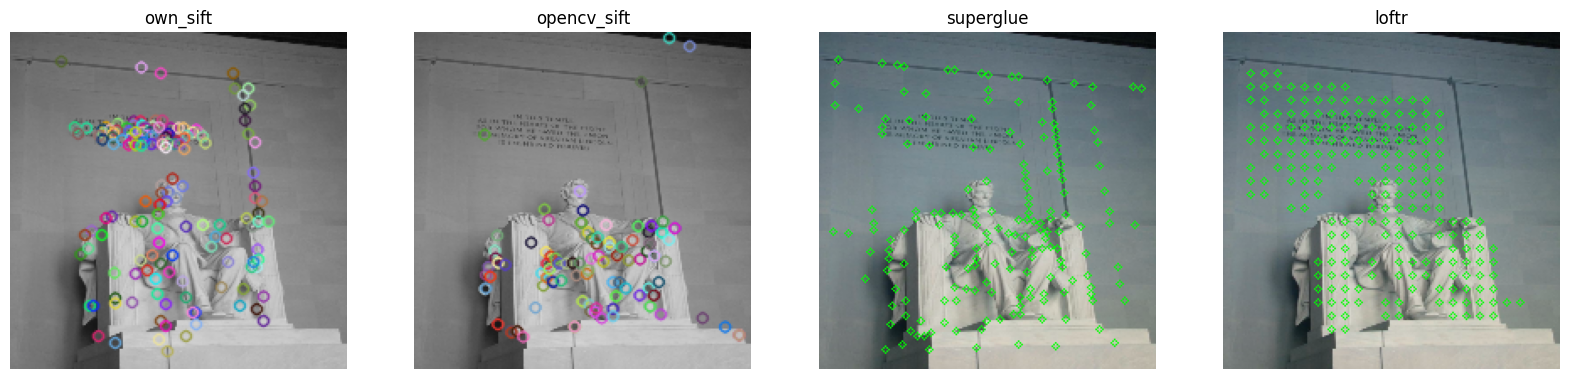

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(20, 7))
images = [img_own, img_opencv, img_superglue, img_loftr]
for i in range(4):
    ax[i].imshow(images[i])
    ax[i].set_title(experiments[i])
    ax[i].axis("off")